# Define function

In [1]:
!nvidia-smi

Thu Apr  6 02:09:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:00:06.0 Off |                  N/A |
| 27%   40C    P8    20W / 250W |      1MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:00:0A.0 Off |                  N/A |
| 29%   

In [2]:
import os
os.environ['TRANSFORMERS_CACHE'] = '/data/tungtx2/tmp/transformers_hub'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import os
import json
from pathlib import Path
import numpy as np
from PIL import Image
import torch

torch.__version__

/data/tungtx2/env_ocr/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.13.1+cu117'

In [3]:
from os import listdir
from torch.utils.data import Dataset
import torch
from PIL import Image
import unidecode
from PIL import Image, ImageDraw, ImageFont
import pdb
import xml.etree.ElementTree as ET
from shapely.geometry import Polygon
import cv2


def normalize_bbox(bbox, width, height):
     return [
         int(1000 * (bbox[0] / width)),
         int(1000 * (bbox[1] / height)),
         int(1000 * (bbox[2] / width)),
         int(1000 * (bbox[3] / height)),
     ]
    
    
def parse_xml(xml_path):
    root = ET.parse(xml_path).getroot()
    objs = root.findall('object')
    boxes, obj_names = [], []
    for obj in objs:
        obj_name = obj.find('name').text
        box = obj.find('bndbox')
        xmin = int(float(box.find('xmin').text))
        ymin = int(float(box.find('ymin').text))
        xmax = int(float(box.find('xmax').text))
        ymax = int(float(box.find('ymax').text))
        boxes.append([xmin, ymin, xmax, ymax])
        obj_names.append(obj_name)
    return boxes, obj_names


def widen_box(box, percent_x, percent_y):
        xmin, ymin, xmax, ymax = box
        w = xmax - xmin
        h = ymax - ymin
        xmin -= w * percent_x
        ymin -= h * percent_y
        xmax += w * percent_x
        ymax += h * percent_y
        return (int(xmin), int(ymin), int(xmax), int(ymax))

    
def draw_json_on_img(img, json_data):
    labels = list(set(shape['label'] for shape in json_data['shapes']))
    color = {}
    for i in range(len(labels)):
        color[labels[i]] = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
        
    img = img.copy()
    draw = ImageDraw.Draw(img)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_size = 0.5# Draw the text on the image
    # font = ImageFont.truetype(font.font.family, font_size)
    for i, shape in enumerate(json_data['shapes']):
        polys = shape['points']
        polys = [(int(pt[0]), int(pt[1])) for pt in polys]
        label = shape['label']
        draw.polygon(polys, outline=color[label], width=2)
        # Draw the text on the image
        img = np.array(img)
        cv2.putText(img, shape['label'], (polys[0][0], polys[0][1]-5), font, font_size, color[label], thickness=1)
        img = Image.fromarray(img)
        draw = ImageDraw.Draw(img)
    return img
    
    
def mask_image(img, boxes, json_data, widen_range_x, widen_range_y):
    # widen block
    if isinstance(widen_range_x, list) and isinstance(widen_range_y, list):
        boxes = [widen_box(box, np.random.uniform(widen_range_x[0], widen_range_x[1]), np.random.uniform(widen_range_y[0], widen_range_y[1])) for box in boxes]
    else:
        boxes = [widen_box(box, widen_range_x, widen_range_y) for box in boxes]
    
    ls_polys2keep = []
    ls_area2keep = []
    iou_threshold = 0.
    for box_idx, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box
        box_pts = [(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)]
        p_box = Polygon(box_pts)
        for shape_idx, shape in enumerate(json_data['shapes']):
            if shape_idx in ls_polys2keep:
                continue
            pts = shape['points']
            p_shape = Polygon(pts)
            intersect_area = p_box.intersection(p_shape).area
            if intersect_area / p_shape.area > iou_threshold:
                ls_polys2keep.append(shape_idx)
                pts = [coord for pt in pts for coord in pt]
                poly_xmin = min(pts[::2])
                poly_ymin = min(pts[1::2])
                poly_xmax = max(pts[::2])
                poly_ymax = max(pts[1::2])
                ls_area2keep.append((poly_xmin, poly_ymin, poly_xmax, poly_ymax))

    # mask white all area of image that is not in block
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        xmin = max(0, xmin)
        ymin = max(0, ymin)
        xmax = min(img.shape[1], xmax)
        ymax = min(img.shape[0], ymax)
        mask[ymin:ymax, xmin:xmax] = 255

    for area2keep in ls_area2keep:
        xmin, ymin, xmax, ymax = area2keep
        xmin = int(max(0, xmin))
        ymin = int(max(0, ymin))
        xmax = int(min(img.shape[1], xmax))
        ymax = int(min(img.shape[0], ymax))
        mask[ymin:ymax, xmin:xmax] = 255

    # mask white
    img[mask == 0] = 255
    
    # draw block on img
    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        draw.rectangle([(xmin, ymin), (xmax, ymax)], outline='red')
    img = np.array(img)

    # delete all poly that is not in block
    ls_idx2del = [idx for idx, shape in enumerate(json_data['shapes']) if idx not in ls_polys2keep]
    for idx in sorted(ls_idx2del, reverse=True):
        del json_data['shapes'][idx]

    return img, json_data
        
def get_random_area_not_in_block(img_w, img_h, block_boxes):
    ls_block_w = [box[2]-box[0] for box in block_boxes]
    ls_block_h = [box[3]-box[1] for box in block_boxes]
    min_w, max_w = min(ls_block_w), max(ls_block_w)
    min_h, max_h = min(ls_block_h), max(ls_block_h)
    w = np.random.randint(min_w, max_w)
    h = np.random.randint(min_h, max_h)
    
    mask = np.zeros((img_h, img_w))
    for xmin, ymin, xmax, ymax in block_boxes:
        mask[ymin:ymax, xmin:xmax] = 1
    for _ in range(10):
        xmin = np.random.randint(0, img_w-w)
        ymin = np.random.randint(0, img_h-h)
        if np.any(mask[ymin:ymin+h, xmin:xmin+w]==1):
            continue
        else:
            return (xmin, ymin, xmin+w, ymin+h)
    
    return None
    
def gen_annotation_for_img(img_fp, xml_fp, json_fp, mask_type='unified', widen_range_x=[0.1, 0.2], widen_range_y=[0.1, 0.25], disable_marker=False, remove_accent=True, augment=False):
    img = Image.open(img_fp).convert("RGB")
    json_data = json.load(open(json_fp))
    
    is_masked = False
    if mask_type == 'masked' or (mask_type=='unified' and np.random.rand() < 0.5):
        block_boxes, obj_names = parse_xml(xml_fp)  # get detected blocks
        
        # if augment and np.random.rand() < 0.3:   # them ngau nhien 1 block bat nham
        #     try:
        #         new_block = get_random_area_not_in_block(img.size[0], img.size[1], block_boxes)
        #         if new_block is not None:
        #             if np.random.rand() < 0.8:
        #                 block_boxes.append(new_block)
        #             else:
        #                 del block_boxes[np.random.randint(0, len(block_boxes))]
        #                 block_boxes.append(new_block)
        #     except:
        #         pass
                
        img, json_data = mask_image(np.array(img), boxes=block_boxes, json_data=json_data, widen_range_x=widen_range_x, widen_range_y=widen_range_y)
        img = Image.fromarray(img)
        is_masked = True
    
    if augment and np.random.rand() < 0.3:  # random drop some boxes
        size = int(0.08*len(json_data['shapes'])) if not is_masked else int(0.05*len(json_data['shapes']))
        idx2drop = np.random.choice(list(range(len(json_data['shapes']))), size=size)
        json_data['shapes'] = [shape for i, shape in enumerate(json_data['shapes']) if i not in idx2drop]
            
    # pdb.set_trace()
        
    words, orig_polys, normalized_boxes, labels = [], [], [], []
    img_h, img_w = json_data['imageHeight'], json_data['imageWidth']
    for i, shape in enumerate(json_data['shapes']):
        if disable_marker and 'marker' in shape['label']:
            current_label = 'text'
        else:
            current_label = shape['label']
        
        if remove_accent:
            words.append(unidecode.unidecode(shape['text'].lower()))
        else:
            words.append(shape['text'].lower())
            
        labels.append(current_label)
        pts = [coord for pt in shape['points'] for coord in pt]
        xmin = min(pts[0::2])
        xmax = max(pts[0::2])
        ymin = min(pts[1::2])
        ymax = max(pts[1::2])

        xmin = max(xmin, 0)
        ymin = max(ymin, 0)
        xmax = min(img_w, xmax)
        ymax = min(img_h, ymax)

        normalized_boxes.append(normalize_bbox((xmin, ymin, xmax, ymax), img_w, img_h))
        orig_polys.append(tuple([tuple(pt) for pt in shape['points']]))
        
    return img, words, orig_polys, normalized_boxes, labels

In [4]:
import pdb
from collections import Counter

def denormalize(bb, img_w, img_h):
  return (
      int(bb[0] / 1000 * img_w),
      int(bb[1] / 1000 * img_h),
      int(bb[2] / 1000 * img_w),
      int(bb[3] / 1000 * img_h),
  )


def predict_batch(backbone_type, img, words, boxes, model=None, processor=None, onnx_sess=None, use_onnx=False, stride=128):
    assert len(words) == len(boxes)
    preds_val = None
    img_w, img_h = img.size
    
    # encode input for model
    encoded_inputs = processor(img, words, boxes=boxes, truncation=True, stride=stride,
                               padding="max_length", max_length=512, return_overflowing_tokens=True, return_offsets_mapping=True, return_tensors="pt")
    encoded_inputs.pop('overflow_to_sample_mapping')
    encoded_inputs.pop('offset_mapping')

    n = len(encoded_inputs['bbox'])
    print(f'{n} split')
    
    if use_onnx:
        input_ids = encoded_inputs['input_ids'].to(device).detach().cpu().numpy()
        bbox = encoded_inputs['bbox'].to(device).detach().cpu().numpy()
        attention_mask = encoded_inputs['attention_mask'].detach().cpu().numpy()
        if backbone_type == 'lilt':
            outputs = onnx_sess.run(
                None,
                {
                    'input_ids': input_ids.astype(np.int64),
                    'bbox': bbox.astype(np.int64),
                    'attention_mask': attention_mask.astype(np.int64)
                }
            )
        elif backbone_type == 'layoutlmv3':
            pixel_values = torch.stack(encoded_inputs['pixel_values'], dim=0).detach().cpu().numpy()
            outputs = onnx_sess.run(
                None,
                {
                    'input_ids': input_ids.astype(np.int64),
                    'bbox': bbox.astype(np.int64),
                    'attention_mask': attention_mask.astype(np.int64),
                    'pixel_values': pixel_values
                }
            )
            
        outputs = outputs[0]
        
    else:
        input_ids = encoded_inputs['input_ids'].to(device)
        bbox = encoded_inputs['bbox'].to(device)
        attention_mask = encoded_inputs['attention_mask'].to(device)
        if backbone_type == 'layoutlmv3':
            pixel_values = torch.stack(encoded_inputs['pixel_values']).to(device)
            outputs = model(pixel_values=pixel_values, input_ids=input_ids, bbox=bbox, attention_mask=attention_mask)
        elif backbone_type == 'lilt':
            outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask)
        else:
            raise ValueError(f'{backbone_type} not supported')
        outputs = outputs.logits
    
    wordidx2label = {}
    for idx in range(len(outputs)):
        # process output
        output = outputs[idx]
        if use_onnx:
            preds_val = output.tolist()
        else:
            preds_val = output.detach().cpu().numpy().tolist()
        words_idx = encoded_inputs.words(idx)
        for i, (pred, wordidx) in enumerate(zip(preds_val, words_idx)):
            if wordidx is None:
                continue
            if wordidx not in wordidx2label:
              wordidx2label[wordidx] = [(np.argmax(pred), np.max(pred))]
            else:
              wordidx2label[wordidx].append((np.argmax(pred), np.max(pred)))

    # wordidx2label = {wordidx: Counter(label).most_common(1)[0][0] for wordidx, label in wordidx2label.items()}
    wordidx2label_final = {}
    for wordidx, label in wordidx2label.items():
        ls_pred_idx = [el[0] for el in label]
        ls_pred_scores = [el[1] for el in label]
        if len(ls_pred_idx) == 2:
            max_score_idx = np.argmax(ls_pred_scores)
            final_label = ls_pred_idx[max_score_idx]
            # print('final_label: ', final_label)
        else:
            final_label = Counter(ls_pred_idx).most_common(1)[0][0]
            
        wordidx2label_final[wordidx] = final_label
    return wordidx2label_final, encoded_inputs

In [5]:
print(np.max([1,2,3,4,5]))
print(np.argmax([1,2,3,4,5]))


5
4


# Define model

In [32]:
from transformers import LayoutLMv3ForTokenClassification, LayoutLMv3Processor

device = 'cuda' if torch.cuda.is_available() else 'cpu'

lmv3_path = 'ckpt/nonmasked/unified_data/last_model_final/lmv3_train+val/checkpoint-19000'
lmv3_model = LayoutLMv3ForTokenClassification.from_pretrained(lmv3_path).eval().to(device)

# lmv3_processor = LayoutLMv3Processor.from_pretrained('microsoft/layoutlmv3-base', apply_ocr=False)
lmv3_processor = LayoutLMv3Processor.from_pretrained(lmv3_path, apply_ocr=False)

lmv3_processor.tokenizer.only_label_first_subword = False

id2label = lmv3_model.config.id2label
label2id = lmv3_model.config.label2id

print(id2label)
print(lmv3_model)
print(lmv3_processor)

{0: 'marker_represented_position', 1: 'represented_name', 2: 'marker_bank_name', 3: 'marker_company_name', 4: 'marker_bank_address', 5: 'text', 6: 'marker_represented_name', 7: 'marker_company_address', 8: 'marker_phone', 9: 'marker_swift_code', 10: 'tax', 11: 'bank_name', 12: 'company_name', 13: 'marker_tax', 14: 'company_address', 15: 'marker_fax', 16: 'marker_account_number', 17: 'fax', 18: 'swift_code', 19: 'represented_position', 20: 'phone', 21: 'bank_address', 22: 'account_number'}
LayoutLMv3ForTokenClassification(
  (layoutlmv3): LayoutLMv3Model(
    (embeddings): LayoutLMv3TextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 1

In [34]:
del lmv3_model

In [5]:
from transformers import LayoutXLMTokenizerFast, LayoutLMv2FeatureExtractor, LayoutXLMProcessor, LiltForTokenClassification

lilt_path = 'ckpt/masked/last_model/lilt_train+val/checkpoint-17000'

# define processor
feature_extractor = LayoutLMv2FeatureExtractor(apply_ocr=False)
tokenizer = LayoutXLMTokenizerFast.from_pretrained(lilt_path)
tokenizer.only_label_first_subword = False
lilt_processor = LayoutXLMProcessor(feature_extractor=feature_extractor, tokenizer=tokenizer)

# define model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lilt_model = LiltForTokenClassification.from_pretrained(lilt_path).eval().to(device)

id2label = lilt_model.config.id2label
label2id = lilt_model.config.label2id
print(lilt_processor.tokenizer)
print(lilt_processor.feature_extractor)
print(lilt_model)

/data/tungtx2/env_ocr/lib/python3.7/site-packages/transformers/models/layoutlmv2/feature_extraction_layoutlmv2.py:33: FutureWarning: The class LayoutLMv2FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv2ImageProcessor instead.
  FutureWarning,


LayoutXLMTokenizerFast(name_or_path='ckpt/masked/last_model/lilt_train+val/checkpoint-17000', vocab_size=250002, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})
LayoutLMv2FeatureExtractor {
  "apply_ocr": false,
  "do_resize": true,
  "image_processor_type": "LayoutLMv2FeatureExtractor",
  "ocr_lang": null,
  "resample": 2,
  "size": {
    "height": 224,
    "width": 224
  },
  "tesseract_config": ""
}

LiltForTokenClassification(
  (lilt): LiltModel(
    (embeddings): LiltTextEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): Layer

In [12]:
del lilt_model

NameError: name 'lilt_model' is not defined

# Define Onnx Model

In [35]:
import onnx
import onnxruntime

onnx_path = 'ckpt/nonmasked/unified_data/last_model_final/lmv3_train+val/checkpoint-19000.onnx'
onnx_sess = onnxruntime.InferenceSession(onnx_path, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])

In [36]:
print(onnxruntime.get_device())
for input in onnx_sess.get_inputs():
    print(input.name, '-', input.type, '-', input.shape)

GPU
input_ids - tensor(int64) - ['batch_size', 512]
bbox - tensor(int64) - ['batch_size', 512, 4]
attention_mask - tensor(int64) - ['batch_size', 512]
pixel_values - tensor(float) - ['batch_size', 3, 224, 224]


# Predict

In [39]:
result_dict = {}
img_dict = {}
# data_dir = 'latest_data_245_final_2/test'
# data_dir = 'ocr2/all_rotated_rois'
data_dir = 'model_output/04042023/test_service_last_model'
# data_dir = 'unified_data_fixed_marker_2/val_labeled_ocred_fixed_marker_2'
mask_type='unmasked'
backbone_type = 'layoutlmv3'
model = None
processor = lmv3_processor
stride = 128
use_block_post_process=False
use_onnx = True
# onnx_sess = None
widen_range_x = 0
widen_range_y = 0.2

for jp in Path(data_dir).rglob('*.json'):
    # if '978_0' not in str(jp):
    #     continue
    
    img, words, orig_polys, normalized_boxes, labels = gen_annotation_for_img(img_fp=jp.with_suffix('.png'), 
                                                       json_fp=jp, 
                                                       xml_fp=jp.with_suffix('.xml'), 
                                                       mask_type=mask_type,
                                                       widen_range_x=widen_range_x,
                                                       widen_range_y=widen_range_y,
                                                       augment=False)

    res_orig, encoding = predict_batch(
        backbone_type, 
        img, 
        words, 
        normalized_boxes, 
        model=model, 
        processor=processor, 
        use_onnx=use_onnx, 
        onnx_sess=onnx_sess,
        stride=stride
    )
    
    res = {}
    for wordidx, pred_label in res_orig.items():
        real_text_label = labels[wordidx] if labels[wordidx] not in ['marker_seller', 'marker_buyer'] else 'marker_company_name'
        res[tuple(orig_polys[wordidx])] = (words[wordidx], pred_label, label2id[real_text_label])
    
    img_dict[jp.with_suffix('.png')] = img
    result_dict[jp.with_suffix('.png')] = res
    print(f'Done {jp}')

2 split
Done model_output/04042023/test_service_last_model/rotated_roi (46th copy).json
1 split
Done model_output/04042023/test_service_last_model/rotated_roi (6th copy).json
1 split
Done model_output/04042023/test_service_last_model/rotated_roi (4th copy).json
2 split
Done model_output/04042023/test_service_last_model/rotated_roi (18th copy).json
2 split
Done model_output/04042023/test_service_last_model/rotated_roi (20th copy).json
2 split
Done model_output/04042023/test_service_last_model/rotated_roi (21st copy).json
2 split
Done model_output/04042023/test_service_last_model/rotated_roi (25th copy).json
2 split
Done model_output/04042023/test_service_last_model/rotated_roi (40th copy).json
2 split
Done model_output/04042023/test_service_last_model/rotated_roi (39th copy).json
1 split
Done model_output/04042023/test_service_last_model/rotated_roi (14th copy).json
2 split
Done model_output/04042023/test_service_last_model/rotated_roi (35th copy).json
1 split
Done model_output/04042023

In [52]:
res_orig

{0: 17,
 1: 17,
 2: 17,
 3: 17,
 4: 17,
 5: 17,
 6: 17,
 7: 17,
 8: 17,
 9: 17,
 10: 17,
 11: 17,
 12: 17,
 13: 17,
 14: 17,
 15: 17,
 16: 17,
 17: 17,
 18: 18,
 19: 18,
 20: 18,
 21: 18,
 22: 18,
 23: 18,
 24: 3,
 25: 18,
 26: 18,
 27: 18,
 28: 18,
 29: 14,
 30: 17,
 31: 8,
 32: 8,
 33: 17,
 34: 17,
 35: 17,
 36: 7,
 37: 6,
 38: 6,
 39: 15,
 40: 15,
 41: 15,
 42: 15,
 43: 15,
 44: 15,
 45: 20,
 46: 15,
 47: 16,
 48: 1,
 49: 16,
 50: 17,
 51: 17,
 52: 17,
 53: 17,
 54: 17,
 55: 17,
 56: 17,
 57: 17,
 58: 17,
 59: 17,
 60: 17,
 61: 17,
 62: 17,
 63: 17,
 64: 17,
 65: 17,
 66: 17,
 67: 17,
 68: 17,
 69: 17,
 70: 17,
 71: 17,
 72: 17,
 73: 17,
 74: 17,
 75: 17,
 76: 17,
 77: 17,
 78: 17,
 79: 17,
 80: 17,
 81: 17,
 82: 17,
 83: 17,
 84: 17,
 85: 17,
 86: 17,
 87: 17,
 88: 17,
 89: 17,
 90: 17,
 91: 17,
 92: 17,
 93: 17,
 94: 17,
 95: 17,
 96: 17,
 97: 17,
 98: 17,
 99: 17,
 100: 17,
 101: 17,
 102: 17,
 103: 17,
 104: 17,
 105: 17,
 106: 17,
 107: 17,
 108: 17,
 109: 17,
 110: 17,
 111: 1

In [33]:
for k, v in res_orig.items():
    print(words[k], ' - ', id2label[v])

:  -  text
packing  -  text
specification  -  text
-  -  text
article 3:  -  text
s.  -  text
phep).  -  text
duoc  -  text
phan  -  text
tung  -  text
hang  -  text
allowed.(giao  -  text
shipment  -  text
is  -  text
partial  -  text
09/2022)  -  text
thang  -  text
den  -  text
07/2022  -  text
thang  -  text
(tu  -  text
2022  -  text
sep  -  text
to  -  text
2022  -  text
jul  -  text
from  -  text
hang)  -  text
(giao  -  text
delivery  -  text
article 2:  -  text
inh  -  text
vietnam.  -  text
-  -  text
city  -  text
hochiminh  -  text
port -  -  text
lai  -  text
cat  -  text
destination :  -  text
china  -  text
:  -  text
departure  -  text
sixty .  -  text
and  -  text
hundred  -  text
nine  -  text
thousand  -  text
one  -  text
twenty  -  text
dollars  -  text
us.  -  text
port  -  text
hcm  -  text
cif  -  text
words:  -  text
in  -  text
mo  -  text
vietnam  -  text
port  -  text
city  -  text
hochiminh  -  text
cif  -  text
price:  -  text
21,960.00  -  text
usd  -  te

In [ ]:
# export result
import shutil

out_dir = 'model_output/06042023/test_service_last_model_final_onnx'
os.makedirs(out_dir, exist_ok=True)
draw_block = True

for img_fp, predictions in result_dict.items():
    json_fp = img_fp.with_suffix('.json')
    json_data = json.load(open(json_fp))

    ls_predicted_polys = predictions.keys()
    for i, shape in enumerate(json_data['shapes']):
        # json_data['shapes'][i]['label'] = 'text'
        poly = tuple([tuple(pt) for pt in shape['points']])
        if poly in ls_predicted_polys:
            json_data['shapes'][i]['label'] = id2label[predictions[poly][1]]
        else:
            # json_data['shapes'][i]['label'] = 'text'
            pass
    
    with open(os.path.join(out_dir, img_fp.with_suffix('.json').name), 'w') as f:
        json.dump(json_data, f)
    
    if draw_block:
        img_dict[img_fp].save(os.path.join(out_dir, img_fp.name))
    else:
        shutil.copy(img_fp, out_dir)
    print(f'Done {img_fp}')

In [ ]:
img_dict[img_fp]

# Evaluate

In [20]:
id2label

{0: 'marker_company_name',
 1: 'marker_represented_position',
 2: 'marker_represented_name',
 3: 'bank_name',
 4: 'fax',
 5: 'marker_account_number',
 6: 'text',
 7: 'marker_swift_code',
 8: 'swift_code',
 9: 'bank_address',
 10: 'company_name',
 11: 'marker_bank_address',
 12: 'phone',
 13: 'tax',
 14: 'marker_tax',
 15: 'marker_phone',
 16: 'represented_position',
 17: 'marker_fax',
 18: 'marker_bank_name',
 19: 'account_number',
 20: 'marker_company_address',
 21: 'company_address',
 22: 'represented_name'}

In [21]:
import yaml

training_config = yaml.load(open(os.path.join(Path(lmv3_path).parent, 'training.yaml')), Loader=yaml.FullLoader)
ls_disable_marker = training_config['training']['data_args']['ls_disable_marker']
ls_disable_marker_id = [label2id[el] for el in ls_disable_marker]
print(ls_disable_marker)
print(ls_disable_marker_id)

[]
[]


In [22]:
from collections import Counter

all_labels = []
for jp in Path(data_dir).rglob('*.json'):
    jdata = json.load(open(jp))
    all_labels.extend([shape['label'] for shape in jdata['shapes']])

cnter = Counter(all_labels)
print(cnter)

Counter({'text': 8614, 'company_address': 961, 'company_name': 491, 'bank_name': 372, 'bank_address': 218, 'represented_name': 158, 'marker_account_number': 112, 'phone': 98, 'marker_represented_name': 97, 'marker_seller': 88, 'marker_bank_name': 76, 'account_number': 74, 'fax': 67, 'marker_phone': 64, 'marker_buyer': 63, 'marker_swift_code': 55, 'represented_position': 51, 'marker_company_name': 51, 'marker_company_address': 48, 'marker_fax': 36, 'swift_code': 31, 'marker_bank_address': 29, 'marker_tax': 7, 'tax': 3, 'marker_represented_position': 1})


In [23]:
# evaluate
from sklearn.metrics import classification_report, confusion_matrix

all_trues, all_preds = [], []
for img_fp, predictions in result_dict.items():
    json_fp = img_fp.with_suffix('.json')
    json_data = json.load(open(json_fp))
    
    poly2label_true = {}
    poly2label_pred = {}
    for i, shape in enumerate(json_data['shapes']):
        poly = tuple([tuple(pt) for pt in shape['points']])
        real_text_label = shape['label'] if shape['label'] not in ['marker_seller', 'marker_buyer'] else 'marker_company_name'
        poly2label_true[poly] = label2id[real_text_label]
        poly2label_pred[poly] = label2id[real_text_label]
    
    for poly, (text, pred, true) in predictions.items():
        poly2label_pred[poly] = pred
    
    poly2label_true = dict(sorted(poly2label_true.items()))
    poly2label_pred = dict(sorted(poly2label_pred.items()))
    all_trues.append(list(poly2label_true.values()))
    all_preds.append(list(poly2label_pred.values()))

for i, true in enumerate(all_trues):
    # print(true)
    # break
    for j in range(len(true)):
        if true[j] in ls_disable_marker_id:
            all_trues[i][j] = label2id['text']

ls_label = sorted(list(set([t for true in all_trues for t in true])))
ls_label = [id2label[id] for id in ls_label]
print(classification_report([t for true in all_trues for t in true], [p for pred in all_preds for p in pred], target_names=ls_label))

                             precision    recall  f1-score   support

        marker_company_name       0.89      0.96      0.92       202
marker_represented_position       1.00      1.00      1.00         1
    marker_represented_name       0.95      0.99      0.97        97
                  bank_name       0.99      0.97      0.98       372
                        fax       0.97      1.00      0.99        67
      marker_account_number       0.92      0.98      0.95       112
                       text       1.00      0.99      0.99      8614
          marker_swift_code       1.00      1.00      1.00        55
                 swift_code       1.00      1.00      1.00        31
               bank_address       0.94      0.97      0.95       218
               company_name       0.96      0.95      0.95       491
        marker_bank_address       1.00      1.00      1.00        29
                      phone       0.98      0.99      0.98        98
                        tax      

In [24]:
import evaluate

metric = evaluate.load("seqeval")

all_trues_labels = [[id2label[t] for t in true] for true in all_trues]
all_preds_labels = [[id2label[p] for p in pred] for pred in all_preds]

results = metric.compute(predictions=all_preds_labels, references=all_trues_labels)
res = {
    "eval_precision": results["overall_precision"],
    "eval_recall": results["overall_recall"],
    "eval_f1": results["overall_f1"],
    "eval_accuracy": results["overall_accuracy"],
}
for k, v in res.items():
    print(k, v)

/data/tungtx2/env_ocr/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: text seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/data/tungtx2/env_ocr/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: marker_company_name seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/data/tungtx2/env_ocr/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: marker_bank_name seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/data/tungtx2/env_ocr/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: marker_bank_address seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/data/tungtx2/env_ocr/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: marker_swift_code seems not to be NE tag.
  warnings.warn('{} seems not to be

eval_precision 0.9370670888581041
eval_recall 0.9552148476901352
eval_f1 0.9460539460539461
eval_accuracy 0.9836493889591235


In [ ]:
!zip -r 'model_output/06042023/test_service_last_model_final_onnx.zip' 'model_output/06042023/test_service_last_model_final_onnx'

# okok

# Export Onnx

In [33]:
def export_model_to_onnx(backbone_type, encoded_inputs, model, out_path, opset_version=14):
    input_ids = encoded_inputs['input_ids'].to(device)
    bbox = encoded_inputs['bbox'].to(device)
    attention_mask = encoded_inputs['attention_mask'].to(device)
    if backbone_type == 'layoutlmv3':
        pixel_values = torch.stack(encoded_inputs['pixel_values'], dim=0).to(device)
    print(input_ids.shape)
    print(bbox.shape)
    print(attention_mask.shape)
    
    if backbone_type == 'lilt':
        torch.onnx.export(
            model,
            (input_ids, bbox, attention_mask),
            out_path,
            input_names=['input_ids', 'bbox', 'attention_mask'],
            output_names = ['output'],
            dynamic_axes = {
                "input_ids": {0: "batch_size"},
                "bbox": {0: "batch_size"},
                "attention_mask": {0: "batch_size"},
                "output": {0: "batch_size"}
            },
            opset_version=opset_version
        )
    elif backbone_type == 'layoutlmv3':
        torch.onnx.export(
            model,
            # (pixel_values, input_ids, bbox, attention_mask),
            ({
                'pixel_values': pixel_values,
                'bbox': bbox,
                'attention_mask': attention_mask,
                'input_ids': input_ids
                
            }),
            out_path,
            input_names=['input_ids', 'bbox', 'attention_mask', 'pixel_values'],
            output_names = ['output'],
            dynamic_axes = {
                "pixel_values": {0: "batch_size"},
                "input_ids": {0: "batch_size"},
                "bbox": {0: "batch_size"},
                "attention_mask": {0: "batch_size"},
                "output": {0: "batch_size"}
            },
            opset_version=opset_version
        )
    
    print(f'Model exported to {out_path}')
    
# export onnx
jp = Path('latest_data_245_final_2/train/val_labeled_ocred_fixed_marker_3/CTR292 (1)-001_0.json')
img, words, orig_polys, normalized_boxes, labels = gen_annotation_for_img(
    img_fp=jp.with_suffix('.jpg'), 
    json_fp=jp, 
    xml_fp=jp.with_suffix('.xml'), 
    mask_type='unmasked',
    widen_range_x=0,
    widen_range_y=0
)

# encode input for model
encoded_inputs = lmv3_processor(img, words, boxes=normalized_boxes, truncation=True, stride=128,
                           padding="max_length", max_length=512, return_overflowing_tokens=True, return_offsets_mapping=True, return_tensors="pt")
encoded_inputs.pop('overflow_to_sample_mapping')
encoded_inputs.pop('offset_mapping')


export_model_to_onnx(
    backbone_type='layoutlmv3',
    encoded_inputs=encoded_inputs,
    model = lmv3_model,
    out_path = lmv3_path+ '.onnx',
)

torch.Size([2, 512])
torch.Size([2, 512, 4])
torch.Size([2, 512])


/data/tungtx2/env_ocr/lib/python3.7/site-packages/transformers/models/layoutlmv3/modeling_layoutlmv3.py:923: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  patch_height, patch_width = int(pixel_values.shape[2] / self.config.patch_size), int(
/data/tungtx2/env_ocr/lib/python3.7/site-packages/transformers/models/layoutlmv3/modeling_layoutlmv3.py:924: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  pixel_values.shape[3] / self.config.patch_size


Model exported to ckpt/nonmasked/unified_data/last_model_final/lmv3_train+val/checkpoint-19000.onnx


# Redundancy

In [25]:
import pdb
from collections import Counter

def denormalize(bb, img_w, img_h):
  return (
      int(bb[0] / 1000 * img_w),
      int(bb[1] / 1000 * img_h),
      int(bb[2] / 1000 * img_w),
      int(bb[3] / 1000 * img_h),
  )


def predict_lilt_batch(img, words, boxes, model=None, onnx_sess=None, use_onnx=False):
    assert len(words) == len(boxes)
    preds_val = None
    img_w, img_h = img.size
    
    # encode input for model
    encoded_inputs = processor(img, words, boxes=boxes, truncation=True, stride=128,
                               padding="max_length", max_length=512, return_overflowing_tokens=True, return_offsets_mapping=True, return_tensors="pt")
    encoded_inputs.pop('overflow_to_sample_mapping')
    encoded_inputs.pop('offset_mapping')

    n = len(encoded_inputs['bbox'])
    print(f'{n} split')
    
    if use_onnx:
        input_ids = encoded_inputs['input_ids'].to(device).detach().cpu().numpy()
        bbox = encoded_inputs['bbox'].to(device).detach().cpu().numpy()
        attention_mask = encoded_inputs['attention_mask'].detach().cpu().numpy()
        outputs = onnx_sess.run(
            None,
            {
                'input_ids': input_ids.astype(np.int64),
                'bbox': bbox.astype(np.int64),
                'attention_mask': attention_mask.astype(np.int64)
            }
        )
        outputs = outputs[0]
    else:
        input_ids = encoded_inputs['input_ids'].to(device)
        bbox = encoded_inputs['bbox'].to(device)
        attention_mask = encoded_inputs['attention_mask'].to(device)
        outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask)
        outputs = outputs.logits
    
    wordidx2label = {}
    for idx in range(len(outputs)):
        # process output
        output = outputs[idx]
        if use_onnx:
            preds_val = output.tolist()
        else:
            preds_val = output.detach().cpu().numpy().tolist()
        words_idx = encoded_inputs.words(idx)
        for i, (pred, wordidx) in enumerate(zip(preds_val, words_idx)):
            if wordidx is None:
                continue
            if wordidx not in wordidx2label:
              wordidx2label[wordidx] = [np.argmax(pred)]
            else:
              wordidx2label[wordidx
                           ].append(np.argmax(pred))

    wordidx2label = {wordidx: Counter(label).most_common(1)[0][0] for wordidx, label in wordidx2label.items()}
    return wordidx2label, encoded_inputs

In [27]:
from transformers import LayoutXLMTokenizerFast, LayoutLMv2FeatureExtractor, LayoutXLMProcessor

feature_extractor = LayoutLMv2FeatureExtractor(apply_ocr=False)
tokenizer = LayoutXLMTokenizerFast.from_pretrained('ckpt/unified/lilt_unified_fixed_marker_2/checkpoint-10250')
tokenizer.only_label_first_subword = False
processor = LayoutXLMProcessor(feature_extractor=feature_extractor, tokenizer=tokenizer)
print(processor.tokenizer)
print(processor.feature_extractor)

LayoutXLMTokenizerFast(name_or_path='ckpt/unified/lilt_unified_fixed_marker_2/checkpoint-10250', vocab_size=250002, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})
LayoutLMv2FeatureExtractor {
  "apply_ocr": false,
  "do_resize": true,
  "image_processor_type": "LayoutLMv2FeatureExtractor",
  "ocr_lang": null,
  "resample": 2,
  "size": {
    "height": 224,
    "width": 224
  },
  "tesseract_config": ""
}



In [28]:
from transformers import LiltForTokenClassification

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LiltForTokenClassification.from_pretrained('ckpt/unified/lilt_unified_fixed_marker_2/checkpoint-10250').eval().to(device)

In [30]:
label2id = model.config.label2id
id2label = model.config.id2label
label2id

{'account_number': 20,
 'bank_address': 19,
 'bank_name': 2,
 'company_address': 7,
 'company_name': 9,
 'fax': 0,
 'marker_account_number': 15,
 'marker_bank_address': 17,
 'marker_bank_name': 1,
 'marker_buyer': 23,
 'marker_company_address': 21,
 'marker_company_name': 13,
 'marker_fax': 12,
 'marker_phone': 5,
 'marker_represented_name': 24,
 'marker_represented_position': 14,
 'marker_seller': 3,
 'marker_swift_code': 4,
 'marker_tax': 11,
 'phone': 6,
 'represented_name': 16,
 'represented_position': 10,
 'swift_code': 8,
 'tax': 18,
 'text': 22}

In [17]:
label2id = {
    'account_number': 3,
    'bank_address': 5,
    'bank_name': 23,
    'company_address': 13,
    'company_name': 11,
    'fax': 0,
    'marker_account_number': 20,
    'marker_bank_address': 24,
    'marker_bank_name': 14,
    'marker_company_address': 15,
    'marker_company_name': 8,
    'marker_fax': 10,
    'marker_phone': 7,
    'marker_represented_name': 2,
    'marker_represented_position': 4,
    'marker_swift_code': 6,
    'marker_tax': 16,
    'phone': 17,
    'represented_name': 18,
    'represented_position': 9,
    'swift_code': 21,
    'tax': 1,
    'text': 12,
    'marker_buyer': 19,
    'marker_seller': 22
}
id2label = {v: k for k, v in label2id.items()}
print(id2label)

{3: 'account_number', 5: 'bank_address', 23: 'bank_name', 13: 'company_address', 11: 'company_name', 0: 'fax', 20: 'marker_account_number', 24: 'marker_bank_address', 14: 'marker_bank_name', 15: 'marker_company_address', 8: 'marker_company_name', 10: 'marker_fax', 7: 'marker_phone', 2: 'marker_represented_name', 4: 'marker_represented_position', 6: 'marker_swift_code', 16: 'marker_tax', 17: 'phone', 18: 'represented_name', 9: 'represented_position', 21: 'swift_code', 1: 'tax', 12: 'text', 19: 'marker_buyer', 22: 'marker_seller'}


In [32]:
result_dict = {}
img_dict = {}
data_dir = 'ocr2/extracted_test/'
mask_type='unmasked'
use_block_post_process=False
use_onnx = False
widen_range_x = 0
widen_range_y = 0.2

for jp in Path(data_dir).rglob('*.json'):
    img, words, orig_polys, normalized_boxes, labels = gen_annotation_for_img(img_fp=jp.with_suffix('.jpg'), 
                                                       json_fp=jp, 
                                                       xml_fp=jp.with_suffix('.xml'), 
                                                       mask_type=mask_type,
                                                       widen_range_x=widen_range_x,
                                                       widen_range_y=widen_range_y)
    res, encoding = predict_lilt_batch(img, words, normalized_boxes, model=model, use_onnx=use_onnx, onnx_sess=None)
    res = {tuple(orig_polys[wordidx]): (words[wordidx], pred_label, label2id[labels[wordidx]]) for wordidx, pred_label in res.items()}
    # res = {tuple(orig_polys[wordidx]): (words[wordidx], pred_label) for wordidx, pred_label in res.items()}
    

    if use_block_post_process:
        xml_fp = jp.with_suffix('.xml')
        block_boxes, block_names = parse_xml(xml_fp)
        block_boxes = [widen_box(box, widen_range_x, widen_range_y) for box in block_boxes]

        if 'bank' in block_names and 'party' in block_names:  # theo mo hinh block
            for poly, (text, pred, true) in res.items():
                pts = list(poly)
                polygon = Polygon(pts)
                is_in_blocks = False
                for box in block_boxes:
                    xmin, ymin, xmax, ymax = box
                    box_pts = [(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)]
                    p_box = Polygon(box_pts)
                    if polygon.intersection(p_box).area > 0:
                        is_in_blocks = True
                        break
                if not is_in_blocks:
                    res[poly] = (text, label2id['text'], true)
        elif 'bank' not in block_names and 'party' in block_names:   # mask phan tren cung
            block_boxes = sorted(block_boxes, key=lambda x: x[1])
            first_block = block_boxes[0]
            ymin = first_block[1]
            for poly, (text, pred, true) in res.items():
                pts = [coord for pt in poly for coord in pt]
                poly_ymax = max(pts[1::2])
                if poly_ymax < ymin:
                    res[poly] = (text, label2id['text'], true)
    
    img_dict[jp.with_suffix('.jpg')] = img
    result_dict[jp.with_suffix('.jpg')] = res
    print(f'Done {jp}')

3 split
Done ocr2/extracted_test/CTR 970_0.json
1 split
Done ocr2/extracted_test/CTR 957_0.json


/data/tungtx2/env_ocr/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:345: FutureWarning: `BatchEncoding.words()` property is deprecated and should be replaced with the identical, but more self-explanatory `BatchEncoding.word_ids()` property.
  FutureWarning,


1 split
Done ocr2/extracted_test/CTR 978_1.json
2 split
Done ocr2/extracted_test/CTR 973_0.json
1 split
Done ocr2/extracted_test/CTR 604_0.json
2 split
Done ocr2/extracted_test/CTR 822_0.json
2 split
Done ocr2/extracted_test/CTR 959_0.json
2 split
Done ocr2/extracted_test/CTR 825_0.json
1 split
Done ocr2/extracted_test/CTR 823_0.json
1 split
Done ocr2/extracted_test/CTR 971_0.json
2 split
Done ocr2/extracted_test/CTR 965_0.json
3 split
Done ocr2/extracted_test/CTR 967_0.json
1 split
Done ocr2/extracted_test/CTR 821_0.json
2 split
Done ocr2/extracted_test/CTR 963_0.json
2 split
Done ocr2/extracted_test/CTR 958_0.json
2 split
Done ocr2/extracted_test/CTR 966_0.json
2 split
Done ocr2/extracted_test/CTR 968_0.json
2 split
Done ocr2/extracted_test/CTR 974_0.json
1 split
Done ocr2/extracted_test/CTR60_0.json
2 split
Done ocr2/extracted_test/CTR 978_0.json
2 split
Done ocr2/extracted_test/CTR 964_0.json
1 split
Done ocr2/extracted_test/CTR 972_0.json
2 split
Done ocr2/extracted_test/CTR 606_0

In [14]:
# evaluate
from sklearn.metrics import classification_report, confusion_matrix

all_trues, all_preds = [], []
for img_fp, predictions in result_dict.items():
    json_fp = img_fp.with_suffix('.json')
    json_data = json.load(open(json_fp))
    
    poly2label_true = {}
    poly2label_pred = {}
    for i, shape in enumerate(json_data['shapes']):
        poly = tuple([tuple(pt) for pt in shape['points']])
        poly2label_true[poly] = label2id[shape['label']]
        poly2label_pred[poly] = label2id[shape['label']]
    
    for poly, (text, pred, true) in predictions.items():
        poly2label_pred[poly] = pred
    
    poly2label_true = dict(sorted(poly2label_true.items()))
    poly2label_pred = dict(sorted(poly2label_pred.items()))
    all_trues.extend(poly2label_true.values())
    all_preds.extend(poly2label_pred.values())

print(classification_report(all_trues, all_preds))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       490
           1       1.00      0.79      0.88       464
           2       1.00      1.00      1.00       208
           3       1.00      0.97      0.98      1493
           4       1.00      1.00      1.00       314
           5       1.00      0.90      0.95       612
           6       1.00      0.99      0.99       426
           7       0.98      1.00      0.99      7566
           8       0.89      1.00      0.94        57
           9       1.00      1.00      1.00       566
          10       1.00      0.39      0.56        89
          11       1.00      0.97      0.98       419
          12       0.98      1.00      0.99        99
          13       0.99      1.00      0.99       235
          14       1.00      0.94      0.97       585
          15       0.96      1.00      0.98      1228
          16       0.95      0.92      0.94      1076
          17       1.00    

In [33]:
# export result
import shutil

out_dir = 'model_output/extracted_test_lilt_fixed_marker_2'
os.makedirs(out_dir, exist_ok=True)
draw_block = False

for img_fp, predictions in result_dict.items():
    json_fp = img_fp.with_suffix('.json')
    json_data = json.load(open(json_fp))

    ls_predicted_polys = predictions.keys()
    for i, shape in enumerate(json_data['shapes']):
        json_data['shapes'][i]['label'] = 'text'
        poly = tuple([tuple(pt) for pt in shape['points']])
        if poly in ls_predicted_polys:
            json_data['shapes'][i]['label'] = id2label[predictions[poly][1]]
        else:
            json_data['shapes'][i]['label'] = 'text'
    
    with open(os.path.join(out_dir, img_fp.with_suffix('.json').name), 'w') as f:
        json.dump(json_data, f)
    
    if draw_block:
        img_dict[img_fp].save(os.path.join(out_dir, img_fp.name))
    else:
        shutil.copy(img_fp, out_dir)
    print(f'Done {img_fp}')

Done ocr2/extracted_test/CTR 970_0.jpg
Done ocr2/extracted_test/CTR 957_0.jpg
Done ocr2/extracted_test/CTR 978_1.jpg
Done ocr2/extracted_test/CTR 973_0.jpg
Done ocr2/extracted_test/CTR 604_0.jpg
Done ocr2/extracted_test/CTR 822_0.jpg
Done ocr2/extracted_test/CTR 959_0.jpg
Done ocr2/extracted_test/CTR 825_0.jpg
Done ocr2/extracted_test/CTR 823_0.jpg
Done ocr2/extracted_test/CTR 971_0.jpg
Done ocr2/extracted_test/CTR 965_0.jpg
Done ocr2/extracted_test/CTR 967_0.jpg
Done ocr2/extracted_test/CTR 821_0.jpg
Done ocr2/extracted_test/CTR 963_0.jpg
Done ocr2/extracted_test/CTR 958_0.jpg
Done ocr2/extracted_test/CTR 966_0.jpg
Done ocr2/extracted_test/CTR 968_0.jpg
Done ocr2/extracted_test/CTR 974_0.jpg
Done ocr2/extracted_test/CTR60_0.jpg
Done ocr2/extracted_test/CTR 978_0.jpg
Done ocr2/extracted_test/CTR 964_0.jpg
Done ocr2/extracted_test/CTR 972_0.jpg
Done ocr2/extracted_test/CTR 606_0.jpg
Done ocr2/extracted_test/CTR 607_0.jpg
Done ocr2/extracted_test/CTR 605_0.jpg
Done ocr2/extracted_test/CT

In [34]:
!zip -r 'model_output/extracted_test_lilt_fixed_marker_2.zip' 'model_output/extracted_test_lilt_fixed_marker_2'

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  adding: model_output/extracted_test_lilt_fixed_marker_2/ (stored 0%)
  adding: model_output/extracted_test_lilt_fixed_marker_2/CTR 970_0.json (deflated 84%)
  adding: model_output/extracted_test_lilt_fixed_marker_2/CTR 973_0.jpg (deflated 6%)
  adding: model_output/extracted_test_lilt_fixed_marker_2/CTR 957_0.json (deflated 84%)
  adding: model_output/extracted_test_lilt_fixed_marker_2/CTR 978_1.json (deflated 84%)
  adding: model_output/extracted_test_lilt_fixed_marker_2/CTR 973_0.json (deflated 84%)
  adding: model_output/extracted_test_lilt_fixed_marker_2/CTR 604_0.json (deflated 84%)
  adding: model_output/extracted_test_lilt_fixed_marker_2/CTR 960_0.jpg (deflat

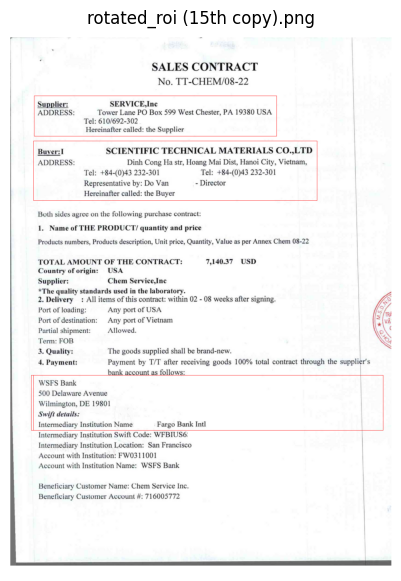

KeyboardInterrupt: Interrupted by user

In [20]:
import matplotlib.pyplot as plt

dir = 'model_output/03042023/test_service_lmv3_full_setting_exclude_aSon_data'
for xml_fp in Path(dir).glob('*.xml'):
    if '15th' not in str(xml_fp):
        continue
    img_fp = xml_fp.with_suffix('.png')
    img = Image.open(img_fp)
    draw = ImageDraw.Draw(img)
    boxes, obj_names = parse_xml(xml_fp)
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        draw.rectangle([(xmin, ymin), (xmax, ymax)], outline='red')
    
    img = np.array(img)
    plt.figure(figsize=(10, 7))
    plt.imshow(img)
    plt.title(img_fp.name)
    plt.axis('off')
    plt.show()
    
    res = input('press n to continue ...')